<h1>Parameter Setting</h1>

Generation of test cosmologies with varied parameters requires criteria to be set for determining what parameter combinations are available. This notebook will specifically be looking for combinations of $w_0$, $w_a$, $h$, $\Omega_b$, and $\Omega_m$ (or equivalently $\Omega_{cdm}$ for a universe with only baryonic and cold dark matter contributions to $\Omega_m$) for a flat universe with a nonzero $w_a$ component in the equation-of-state parameter for dark energy.

To avoid unphysical perturbations from a fluid model where $w(z) = -1$ at any redshift, the constant component of $w$ is taken to be
$$w_0 = -1 + \epsilon,$$
where the sign of $\epsilon$ is the sign of $w_a$. The magnitude of $\epsilon$ is taken to keep the effects of a nonzero $\epsilon$ small compared to the effects of $w_a$. The magnitude of $w_a$ is taken to induce a deviation from a flat cosmological constant model on the same order as a model with $w(z) = -1 \pm 0.1$.

Determination of values for potential $\Omega_m$, and $\Omega_b$ values are made by maintaining constant values of $h^2 \Omega_m$ and $h^2 \Omega_b$ for potential $h$ values \[1]. A single set of $h$, $\Omega_b$, and $\Omega_m$ is chosen by holding the distance of the last scattering constant. The redshift at last scattering is aprroximated as $z_* = 1091$, and baseline values for $h^2 \Omega_m$, $h^2 \Omega_b$, and $D_*$ are taken from a flat model with a cosmological constant.

\[[1](http://arxiv.org/abs/1201.2434v2)] Weinberg, D., Mortonson, M., Eisenstein, D., Hirata, C., Riess, A., and Rozo, E. (2013) "Observational Probes of Cosmic Acceleration."

In [12]:
%pylab inline
import scipy.integrate
from astropy import cosmology, units as u, constants as const
from classy import Class

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [17]:
Z_lss = 1091.0
cosmo1 = cosmology.FlatLambdaCDM(71.0, 0.222 + 0.045, Ob0 = 0.045)

In [3]:
def get_class_parameters(cosmology):
    """
    Get CLASS parameters corresponding to an astropy cosmology model.
    """
    class_parameters = {}
    try:
        class_parameters['h'] = cosmology.h
        class_parameters['T_cmb'] = cosmology.Tcmb0.value
        class_parameters['Omega_b'] = cosmology.Ob0
        # CDM = DM - massive neutrinos.
        class_parameters['Omega_cdm'] = cosmology.Om0 - cosmology.Ob0
        class_parameters['Omega_k'] = cosmology.Ok0
        # Dark energy sector. CLASS will calculate whichever of
        # Omega_Lambda/fld/scf we do not provide.
        class_parameters['Omega_scf'] = 0.
        try:
            # Only subclasses of wCDM have the w0 attribute.
            class_parameters['w0_fld'] = cosmology.w0
            class_parameters['wa_fld'] = cosmology.wa
            class_parameters['Omega_Lambda'] = 0.
        except AttributeError:
            class_parameters['Omega_fld'] = 0.
        # Neutrino sector.
        if cosmology.has_massive_nu:
            m_nu = cosmology.m_nu
            try:
                num_massive = len(m_nu)
            except TypeError:
                num_massive = 3
                m_nu = [num_massive * m_nu]
            if num_massive > 3:
                raise RuntimeError(
                    'Cannot calculate cosmology with >3 massive neutrinos.')
            m_ncdm = []
            for mass in m_nu:
                if mass > 0:
                    m_ncdm.append(repr(mass.value))
                else:
                    num_massive -= 1
            if num_massive > 0:
                class_parameters['m_ncdm'] = ','.join(m_ncdm)
        else:
            num_massive = 0
        class_parameters['N_ncdm'] = num_massive
        num_light = 3 - num_massive
        class_parameters['N_ur'] = (3.00641 - num_massive +
            num_light*(cosmology.Neff - 3.00641)/3.)
    except AttributeError:
        raise ValueError('Cosmology is missing required attributes.')
    return class_parameters

In [4]:
cosmo = Class()

Here we find the values to maintain for $h^2 \Omega_b$, $h^2 \Omega_m$, and $D_*$.

In [24]:
print('Base numbers:')
cosmo.set(get_class_parameters(cosmo1))
cosmo.compute()
h2b = cosmo.omega_b()
h2m = cosmo.Omega_m() * cosmo.h() ** 2
dist = cosmo.angular_distance(Z_lss)
cosmo.struct_cleanup()
cosmo.empty()
print(h2b)
print(h2m)
print(dist)

Base numbers:
0.0226845
0.1345947
12.8764593039


Values of $h$ between $0.6$ and $0.8$ were tested along with values of $\Omega_b$ and $Omega_m$ rounded to the nearest thousandth.

In [13]:
h = np.linspace(0.6,0.8,num=201)
b = np.around(h2b * h ** -2, decimals = 3)
m = np.around(h2m * h ** -2, decimals = 3)
c = m - b

In [14]:
def params_pos():
    test = {}
    test['N_ncdm'] = 0.0
    test['N_ur'] = 3.04
    test['Omega_Lambda'] = 0.0
    test['Omega_scf'] = 0.0
    test['Omega_k'] = 0.0
    test['w0_fld'] = -1.0 + 0.01
    test['wa_fld'] = 0.5
    test['T_cmb'] = 2.725
    return test
def params_neg():
    test = {}
    test['N_ncdm'] = 0.0
    test['N_ur'] = 3.04
    test['Omega_Lambda'] = 0.0
    test['Omega_scf'] = 0.0
    test['Omega_k'] = 0.0
    test['w0_fld'] = -1.0 - 0.01
    test['wa_fld'] = -0.5
    test['T_cmb'] = 2.725
    return test

Values of $w_0 = -1.0 \pm 0.01$ and $w_a = \pm 0.5$ were chosen to keep the effect of $\epsilon$ small compared to $w_a$.

In [25]:
trial = []
print('w0 = -0.99, wa = 0.5:')
for i in range(201):
    test = params_pos()
    test['h'] = h[i]
    test['Omega_b'] = b[i]
    test['Omega_cdm'] = c[i]
    cosmo.set(test)
    cosmo.compute()
    trial.append(np.abs(dist - cosmo.angular_distance(Z_lss)))
    cosmo.struct_cleanup()
    cosmo.empty()
j = np.argmin(trial)
print("h = {}, Om = {}, Ob = {}".format(h[j],m[j],b[j]))

w0 = -0.99, wa = 0.5:
h = 0.65, Om = 0.319, Ob = 0.054


In [9]:
trial = []
print('w0 = -1.01, wa = -0.5:')
for i in range(201):
    test = params_neg()
    test['h'] = h[i]
    test['Omega_b'] = b[i]
    test['Omega_cdm'] = c[i]
    cosmo.set(test)
    cosmo.compute()
    trial.append(np.abs(dist - cosmo.angular_distance(Z_lss)))
    cosmo.struct_cleanup()
    cosmo.empty()
k = np.argmin(trial)
print("h = {}, Om = {}, Ob = {}".format(h[k],m[k],b[k]))

w0 = -1.01, wa = -0.5:
h = 0.76, Om = 0.233, Ob = 0.039


This test returns optimal parameter values for these two $w(z)$ cosmologies:
 - $w(z) = -0.99 + 0.5 \frac{z}{1+z}$:
  - $h = 0.650$
  - $\Omega_m = 0.319$
  - $\Omega_b = 0.054$
 - $w(z) = -1.01 - 0.5 \frac{z}{1+z}$:
  - $h = 0.760$
  - $\Omega_m = 0.233$
  - $\Omega_b = 0.039$

In order to determine whether or not $\epsilon$ was chosen to be small enough to have negligible effects compared to $w_a$, this process of finding parameters is repeated for cosmologies with $w_0 = -1.0 \pm \epsilon$ and $w_a = 0$. Then the nonzero $w_a$ models are plotted against the $w_a = 0$ models for visual comparison.

In [26]:
trial = []
print('w0 = -0.99, wa = 0.0:')
for i in range(201):
    test = params_pos()
    test['wa_fld'] = 0.0
    test['h'] = h[i]
    test['Omega_b'] = b[i]
    test['Omega_cdm'] = c[i]
    cosmo.set(test)
    cosmo.compute()
    trial.append(np.abs(dist - cosmo.angular_distance(Z_lss)))
    cosmo.struct_cleanup()
    cosmo.empty()
r = np.argmin(trial)
print("h = {}, Om = {}, Ob = {}".format(h[r],m[r],b[r]))

w0 = -0.99, wa = 0.0:
h = 0.704, Om = 0.272, Ob = 0.046


In [27]:
trial = []
print('w0 = -1.01, wa = 0.0:')
for i in range(201):
    test = params_neg()
    test['wa_fld'] = 0.0
    test['h'] = h[i]
    test['Omega_b'] = b[i]
    test['Omega_cdm'] = c[i]
    cosmo.set(test)
    cosmo.compute()
    trial.append(np.abs(dist - cosmo.angular_distance(Z_lss)))
    cosmo.struct_cleanup()
    cosmo.empty()
s = np.argmin(trial)
print("h = {}, Om = {}, Ob = {}".format(h[s],m[s],b[s]))

w0 = -1.01, wa = 0.0:
h = 0.715, Om = 0.263, Ob = 0.044


In [32]:
Z = np.linspace(0,3,num=901)
cosmo5 = cosmology.Flatw0waCDM(65.0, 0.319, w0 = -0.99, wa = 0.5, Ob0 = 0.054)
cosmo15 = cosmology.Flatw0waCDM(76.0, 0.233, w0 = -1.01, wa = -0.5, Ob0 = 0.039)
cosmo99 = cosmology.Flatw0waCDM(70.4, 0.272, w0 = -0.99, Ob0 = 0.046)
cosmo101 = cosmology.Flatw0waCDM(71.5, 0.263, w0 = -1.01, Ob0 = 0.044)

In [15]:
def plot_comp(x, y, title1, title2, comp1=None, comp2=None, comp3=None, comp4=None,
              comp5 = None, comp6 = None, compfill = None, xlabel = '$z$', xscale = None,
              yscale = None, xlim = None, mainylim = None, diffylim = None,
              mainlabel = '$\mathrm{flat} \; \Lambda CDM$'):
    """
    Plots y and comparisons of the form Delta y / y. 
    
    Arguments:
        x (np.array): independent axis
        y (np.array): dependent axis to be compared against
        title1 (str): y-axis label for original plot
        title2 (str): y-axis label for comparison plot
        comp1-4 (tuple of (np.array, str)): Comparison y axis data and legend entry
        compfill (tuple of (np.array, np.array)): Error to fill in difference plot
        xlabel (str): x-axis label for both plots
    """
    plt.figure(figsize = (6,6.5))
    gs = matplotlib.gridspec.GridSpec(2,1,height_ratios=[8,3])
    gs.update(hspace=0.05)
    
    ax1 = plt.subplot(gs[0])
    ax1.plot(x, y, 'k-', linewidth = 1.5)
    ax1.set_ylabel(title1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    if xscale:
        ax1.set_xscale(xscale)
    if yscale:
        ax1.set_yscale(yscale)
    if mainylim:
        ax1.set_ylim(mainylim)
    
    
    ax2 = plt.subplot(gs[1], sharex = ax1)
    ax2.plot(x, np.zeros(len(x)), 'k-', linewidth = 1.5, label = mainlabel)
    if compfill:
        ax2.fill_between(x, compfill[0], compfill[1], color = 'k', alpha = 0.2)
    if comp1:
        ax2.plot(x, (comp1[0]-y)/y, 'r:',  linewidth = 1.5, label = comp1[1])
    if comp2:
        ax2.plot(x, (comp2[0]-y)/y, 'b--',  linewidth = 1.5, label = comp2[1])
    if comp3:
        ax2.plot(x, (comp3[0]-y)/y, 'y--',  linewidth = 1.5, dashes = (15,5), label = comp3[1])
    if comp4:
        ax2.plot(x, (comp4[0]-y)/y, 'g-.',  linewidth = 1.5, label = comp4[1])
    if comp5:
        ax2.plot(x, (comp5[0]-y)/y, 'c:',  linewidth = 1.5, label = comp5[1])
    if comp6:
        ax2.plot(x, (comp6[0]-y)/y, 'm--',  linewidth = 1.5, label = comp6[1])
    ax2.set_ylabel(title2)
    ax2.set_xlabel(xlabel)
    if diffylim:
        ax2.set_ylim(diffylim)
    if xlim:
        ax1.set_xlim(xlim)
    
    handles, labels = ax2.get_legend_handles_labels()
    ax1.legend(handles, labels, loc = 0, frameon = False, handlelength = 3.5)
    
    plt.show()

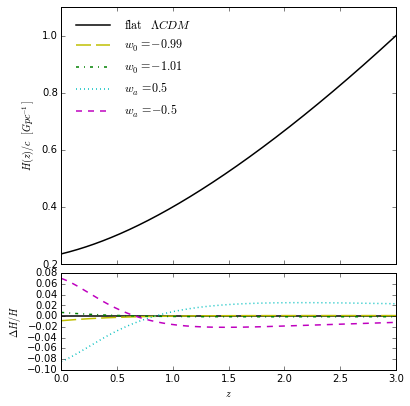

In [31]:
plot_comp(Z, (cosmo1.H(Z) / const.c).to(1 / u.Gpc), '$H (z) / c$  $[Gpc^{-1}]$', '$\Delta H/H$',
          comp3=((cosmo99.H(Z) / const.c).to(1 / u.Gpc), '$w_0=-0.99$'),
          comp4=((cosmo101.H(Z) / const.c).to(1 / u.Gpc), '$w_0=-1.01$'),
          comp5=((cosmo5.H(Z) / const.c).to(1 / u.Gpc), '$w_a=0.5$'),
          comp6=((cosmo15.H(Z) / const.c).to(1 / u.Gpc), '$w_a=-0.5$'))

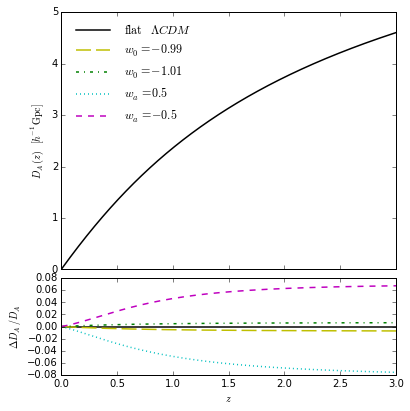

In [38]:
plot_comp(Z[1:], cosmo1.comoving_transverse_distance(Z[1:]).to('Gpc') * cosmo1.h,
          r'$D_A (z) \; [h^{-1} \mathrm{Gpc}]$', '$\Delta D_A/D_A$',
          comp3=(cosmo99.comoving_transverse_distance(Z[1:]).to('Gpc') * cosmo99.h, '$w_0=-0.99$'),
          comp4=(cosmo101.comoving_transverse_distance(Z[1:]).to('Gpc') * cosmo101.h, '$w_0=-1.01$'),
          comp5=(cosmo5.comoving_transverse_distance(Z[1:]).to('Gpc') * cosmo5.h, '$w_a=0.5$'),
          comp6=(cosmo15.comoving_transverse_distance(Z[1:]).to('Gpc') * cosmo15.h, '$w_a=-0.5$'))

In [36]:
def loggrow(z, arg1):
    """
    Returns approximate value of logrithmic derivative of Growth function
    
    Arguments:
        z (np.array): redshift values to evaluate at
        arg1 (astropy.cosmology.w0waCDM): w0waCDM object containing information on universe to analyze
    
    Returns
        f (np.array): approximate values of the growth function logrithmic derivative
    """
    Om, H0 = (arg1.Om0, arg1.H0)
    try:
        w0, wa = (arg1.w0, arg1.wa)
    except AttributeError:
        w0, wa = (-1.0, 0.0)
    w = w0 + wa / 2
    gamma = 0.55 + 0.05 * (1 + w)
    Omz = (Om * (1 + z) ** 3 * H0 ** 2
                 / (arg1.H(z) ** 2)).to(1)
    f = Omz ** gamma
    return f

def Growth2(z, arg1):
    """
    Returns approximate value of Growth function (z <= 9)
    
    Arguments:
        z (np.array): descending redshift values to evaluate at (first entry must be 9.0)
        arg1 (astropy.cosmology.w0waCDM): w0waCDM object containing information on universe to analyze
    
    Returns
        grow (np.array): approximate values of the growth function
    """
    integrand = -1 * loggrow(z, arg1) / (1 + z)
    exponent = scipy.integrate.cumtrapz(integrand, z, initial = 0)
    grow = np.exp(exponent)
    return grow

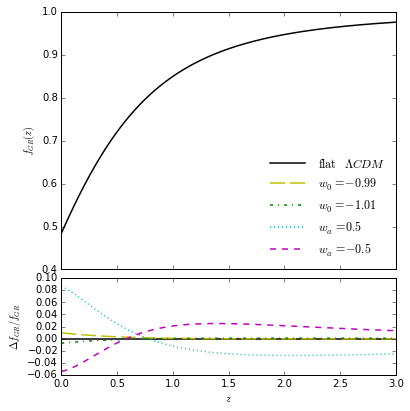

In [37]:
plot_comp(Z, loggrow(Z, cosmo1), '$f_{GR}(z)$', '$\Delta f_{GR}/f_{GR}$',
          comp3=(loggrow(Z, cosmo99), '$w_0=-0.99$'),
          comp4=(loggrow(Z, cosmo101), '$w_0=-1.01$'),
          comp5=(loggrow(Z, cosmo5), '$w_a=0.5$'),
          comp6=(loggrow(Z, cosmo15), '$w_a=-0.5$'))

The nonzero $w_a$ cosmologies appear to have a much larger deviation from a $\Lambda \mathrm{CDM}$ model than the $w_a = 0$ cosomologies.